# Explainability CNN from scratch

In [ ]:
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth
from keras.utils import image_dataset_from_directory

In [ ]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/Shareddrives/Progetto_CIDL/Models/CNN_from_scratch.h5"

IMG_SIZE = 96

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(model_path)
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 85, 85, 32)        13856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 84, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 84, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 256)       73984 

This will be the input image we will use. The picture is not part of images that the network was trained on:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
img_path = "/content/drive/Shareddrives/Progetto_CIDL/test_russula.jpg"
# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Its shape is (1, 180, 180, 3)
print(img_tensor.shape)

(1, 96, 96, 3)


Here the picture is shown

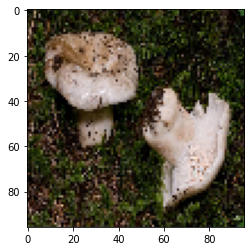

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In order to extract the feature maps we want to look at, we will create a tf.keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. 

In [ ]:
print(type(model.layers))
print(len(model.layers))
model.layers # is a list of layers 

<class 'list'>
12


In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2


In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2


In [ ]:
layer_names

['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2']

In [ ]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
print(len(activations))
for out in activations:
  print(out.shape)

1/1 [==============================] - 0s 294ms/step
5
(1, 85, 85, 32)
(1, 84, 84, 32)
(1, 84, 84, 256)
(1, 42, 42, 256)
(1, 42, 42, 384)


Now we activate the first convolution layer for our image input and then try to visualize it

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 85, 85, 32)


After this we want to visualize the 32 channels of the first layer

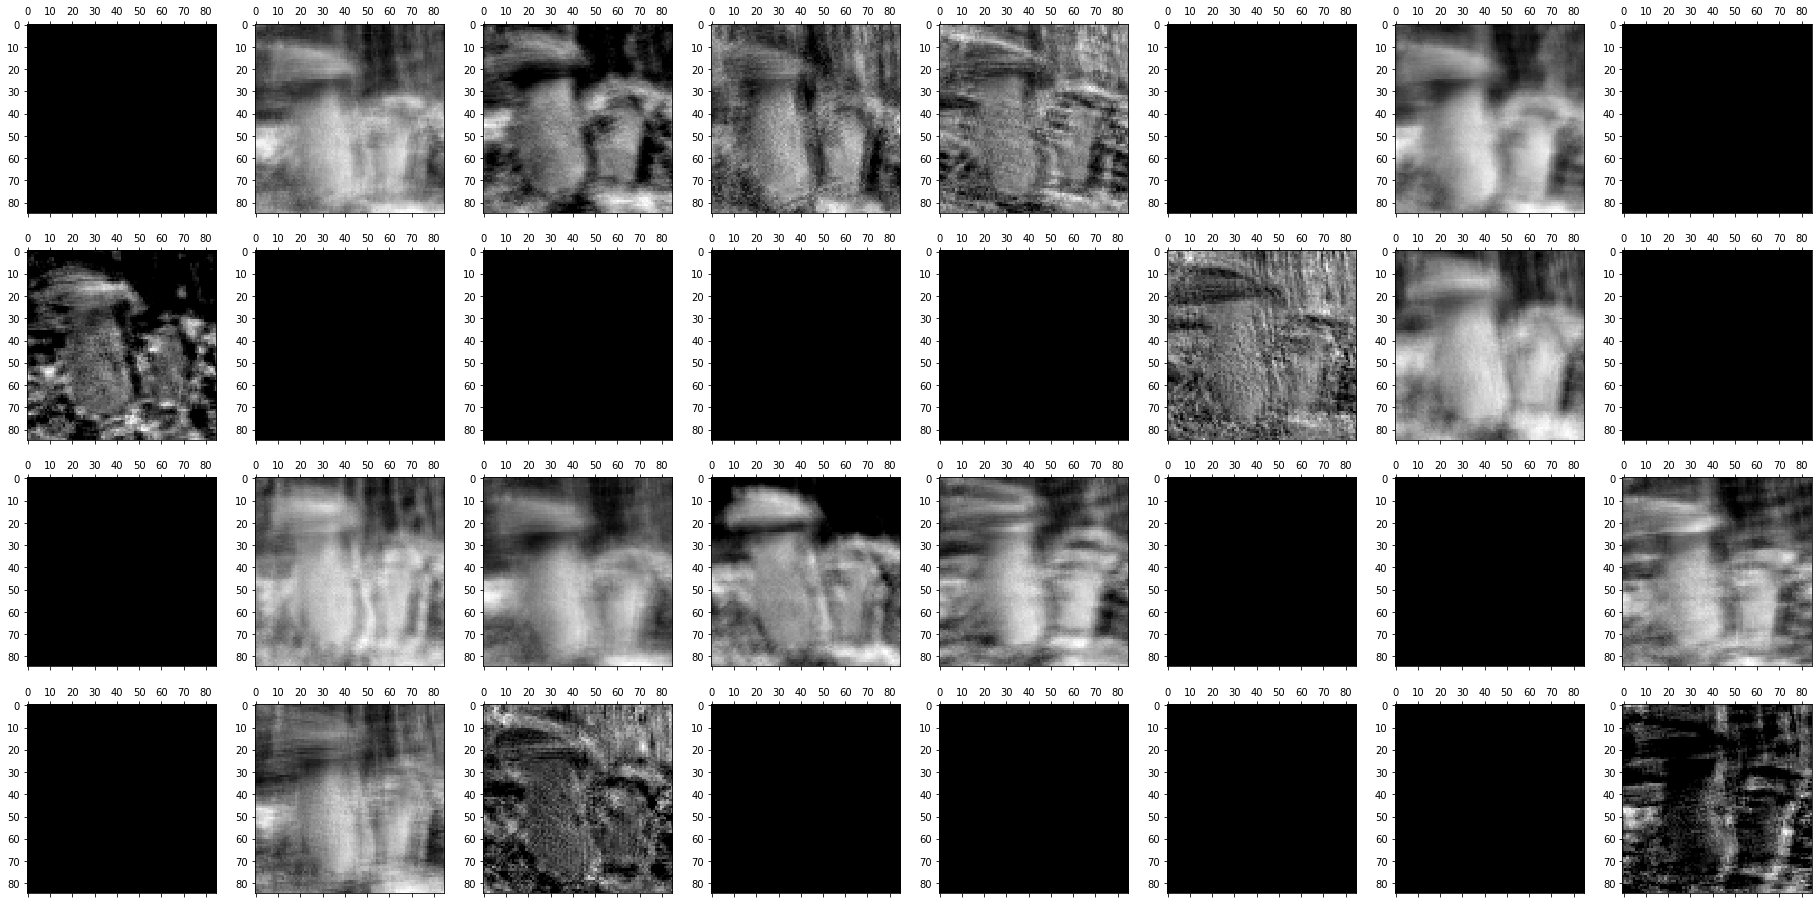

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 8, figsize=(32, 16))
for k in range(8):
    ax[0, k].matshow(first_layer_activation[0, :, :, k], cmap='gray')
    ax[1, k].matshow(first_layer_activation[0, :, :, k+8], cmap='gray')
    ax[2, k].matshow(first_layer_activation[0, :, :, k+16], cmap='gray')
    ax[3, k].matshow(first_layer_activation[0, :, :, k+24], cmap='gray')
plt.show()

Now let's plot a complete visualization of all the activations in the network.  

In [ ]:
images_per_row = 16

In [ ]:
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

##Visualizing convnet filters

In this part we are going to display the visual pattern that each filter is meant to respond to, so which input image maximizes the response of a specific filter.

Retrieve the name of all the convolutional layers in the model

In [ ]:
for layer in model.layers:
  if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D)):
    print(layer.name)

conv2d
conv2d_1
conv2d_2


Create a new model that acts as a *specific* feature extractor.

In [ ]:
layer_name = "conv2d_1"
layer = model.get_layer(name=layer_name)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=layer.output)

In [ ]:
activation = feature_extractor(
    tf.keras.applications.xception.preprocess_input(img_tensor)
)

Let’s use our feature extractor model to define a function that returns a scalar value quantifying how much a given input image "activates" a given filter in the layer. This is the "loss  function" (or *fitness*) that will be maximized.

In [ ]:
def compute_loss(image, layer_name, filter_index):
  ''' compute loss for gradient ascent
  
  image: input image tensor
  layer_name: name of the conv layer we are considering
  filter index: index of the filter we are considering (i.e., feature map of the output of a given conv layer) 
  '''
  layer = model.get_layer(name=layer_name)
  feature_extractor = tf.keras.Model(inputs=model.input, outputs=layer.output)
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index] # avoid border artifacts
  return tf.reduce_mean(filter_activation) # return mean activation values for the filter

Gradient ascent step function definition

In [ ]:
def gradient_ascent_step(image, layer_name, filter_index, learning_rate):
    with tf.GradientTape() as tape: # inside the scope, perform some tensor operations
        tape.watch(image) # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable (only Variables are automatically watched in a gradient tape).
        loss = compute_loss(image, layer_name, filter_index) # how much the current image activates the filter.
    # then, outside the scope, retrieve the gradients based on the "recorded" variables
    grads = tape.gradient(loss, image) # Compute the gradients of the loss with respect to the image.
    grads = tf.math.l2_normalize(grads) # gradient normalization trick
    image += learning_rate * grads # Move the image a little bit in a direction that activates our target filter more strongly.
    return image

In [ ]:
def generate_filter_pattern(layer_name, filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform( # initialize an image tensor with random values in the range centered in 0.5
        minval=0.4,
        maxval=0.6,
        shape=(1, IMG_SIZE, IMG_SIZE, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, layer_name, filter_index, learning_rate)
    return image[0].numpy()

Results visualization

In [ ]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :] #avoid border artifacts
    return image

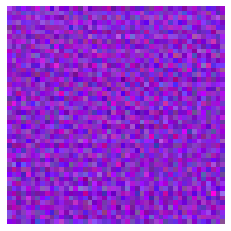

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(layer_name, filter_index=2)))

Now we can start visualizing the preferred pattern for every single filter in every layer

In [ ]:
all_images = []
for filter_index in range(16):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(layer_name, filter_index)
    )
    all_images.append(image)

margin = 5
n = 4
cropped_width = IMG_SIZE - 25 * 2
cropped_height = IMG_SIZE - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15


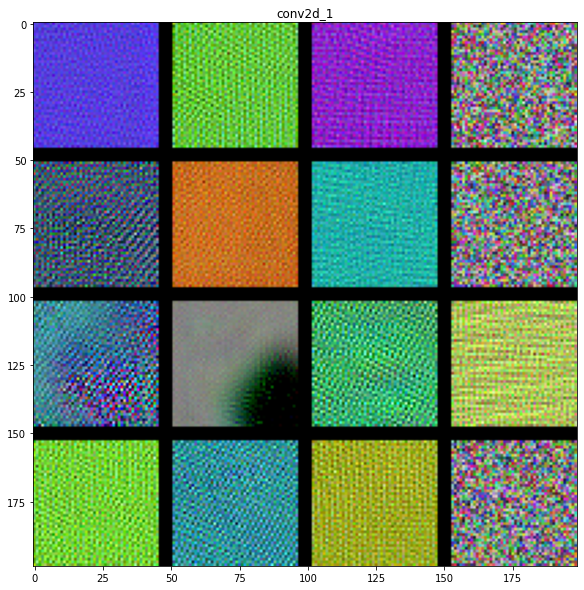

In [ ]:
plt.figure(figsize=(10, 10))
plt.title(layer_name)
plt.imshow(stitched_filters.astype("uint8"))
plt.show()

## Visualizing heatmaps of class activation

In this section we want to visualize heatmaps of class activation. In this way we create a 2D grid of scores associated with specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered.

In [ ]:
def get_img_array(img_path, target_size):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_array = get_img_array(img_path, target_size=(IMG_SIZE, IMG_SIZE))

Using the model to classify the input image

In [ ]:
preds = model.predict(img_array)

1/1 [==============================] - 7s 7s/step


For the GradCAM process, we need a custom model that maps the input image to the activations of the last convolutional layer

In [ ]:
last_conv_layer_name = "conv2d_2" # output shape (None, 84, 84, 384)
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

Then we create a model that maps the activationbs of the last convolutional layer to the final class predictions

In [ ]:
classifier_layer_names = [
    "global_max_pooling2d",
    "flatten",
    "dropout",
    "classifier",
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

#classifier_model.summary()

We compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer

In [ ]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) # output feature maps of the last conv layer.
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)  
    top_pred_index = tf.argmax(preds[0])  #  "Boletus" index
    top_class_channel = preds[:, top_pred_index] # "Boletus" prediction value
    print(top_pred_index)
    print(top_class_channel)

grads = tape.gradient(top_class_channel, last_conv_layer_output) # gradient of the "Boletus" class with regard to the output feature maps of our last conv layer

tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor([0.5496696], shape=(1,), dtype=float32)


In [ ]:
grads.shape # same shape of conv2d_2 output

TensorShape([1, 42, 42, 384])

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately --> returns a vector of 384 elements
print(pooled_grads.shape)
weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]

(384,)


The channel-wise mean of the resulting feature map is our heatmap of class activation

In [ ]:
heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)

Normalization trick for visualization

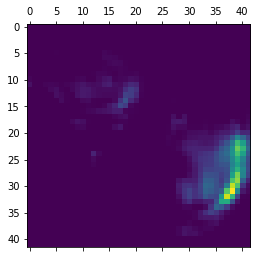

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Superimpose the heatmap to the original image

In [ ]:
import matplotlib.cm as cm

img = tf.keras.utils.load_img(img_path)
img = tf.keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

save_path = "/content/drive/Shareddrives/Progetto_CIDL/russula_scratch.jpg"
superimposed_img.save(save_path)

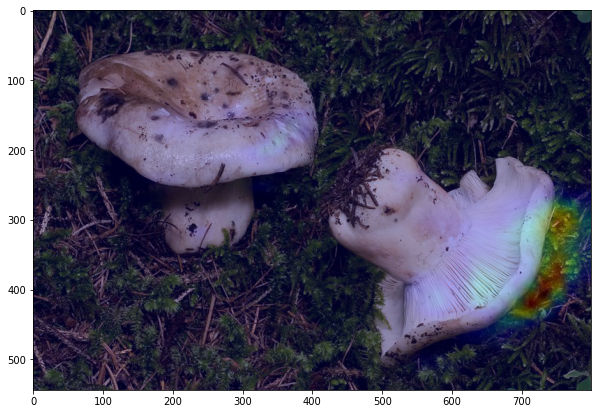

In [ ]:
plt.figure(figsize= (10,10))
plt.imshow(superimposed_img)